# Aim

The aim of the anaylsis is to investigate the relashionship between neurons identified in the same ensemble and the neurons that do not appear in the same ensemble. We expect that neurons in the same ensemble have more synchronous firing and thus higher correlation among them, compared to neurons not in the same emsemble. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal, stats
from scipy.stats import zscore


# get colors for box plots
colors = sns.color_palette("Paired")
A1_color = (colors[1], colors[0], colors[3], colors[2])
MGB_color = (colors[5], colors[4], colors[7], colors[6])
colors = list(MGB_color) + list(A1_color)

## Load Data 

In [2]:
datafolder = 'E:\Congcong\Documents\data\comparison\data-summary'
df = pd.read_json(os.path.join(datafolder, 'member_nonmember_pair_xcorr.json'))

## Inspect Data

In [3]:
df.head()
# member: True if the two neurons in the pair appeared the same cNE, otherwise, false
# stim: True if the dmr is played during the activity
# region: MGB or A1

,xcorr,corr,member,stim,region,exp
0,"[18, 24, 19, 21, 21, 31, 17, 28, 18, 24, 17, 1...",0.014194,True,dmr,MGB,191126211411
1,"[60, 58, 48, 54, 62, 58, 55, 55, 82, 60, 56, 6...",0.037981,True,dmr,MGB,191126211411
2,"[119, 132, 117, 122, 122, 116, 132, 109, 120, ...",0.079390,True,dmr,MGB,191126211411
3,"[100, 104, 104, 92, 97, 74, 96, 87, 98, 81, 10...",0.070183,True,dmr,MGB,191126211411
4,"[93, 86, 107, 106, 105, 104, 99, 99, 96, 128, ...",0.031959,True,dmr,MGB,191126211411


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17717 entries, 0 to 17716
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xcorr   17717 non-null  object 
 1   corr    17717 non-null  float64
 2   member  17717 non-null  bool   
 3   stim    17717 non-null  object 
 4   region  17717 non-null  object 
 5   exp     17717 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(3)
memory usage: 847.8+ KB


In [5]:
df['stim'].unique()

array(['dmr', 'spon'], dtype=object)

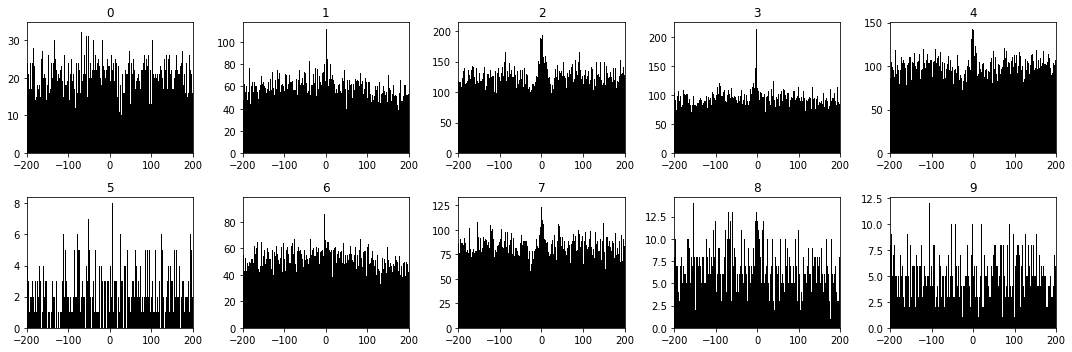

In [6]:
# peek a few CCGs
fig, axes = plt.subplots(2, 5, figsize=[15, 5]) 
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.bar(range(-200, 201), df['xcorr'][i], 1, color='k')
    ax.set_xlim([-200, 200])
    ax.set_title(i)
plt.tight_layout()

## Add Features

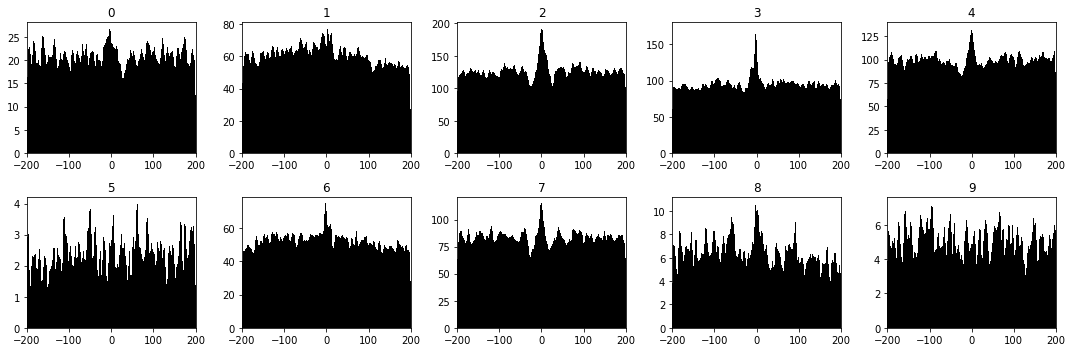

In [7]:
# as the the CCG is noisy, especially for the ondes with less spikes, we can filter the CCGs to make them more smooth
window = signal.windows.gaussian(11, std=2) # 1ms gaussian window
window = window / window.sum()
df['xcorr_filtered'] = df['xcorr'].apply(lambda x: np.convolve(window,x, mode='same'))
fig, axes = plt.subplots(2, 5, figsize=[15, 5]) 
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.bar(range(-200, 201), df['xcorr_filtered'][i], 1, color='k')
    ax.set_xlim([-200, 200])
    ax.set_title(i)
plt.tight_layout()

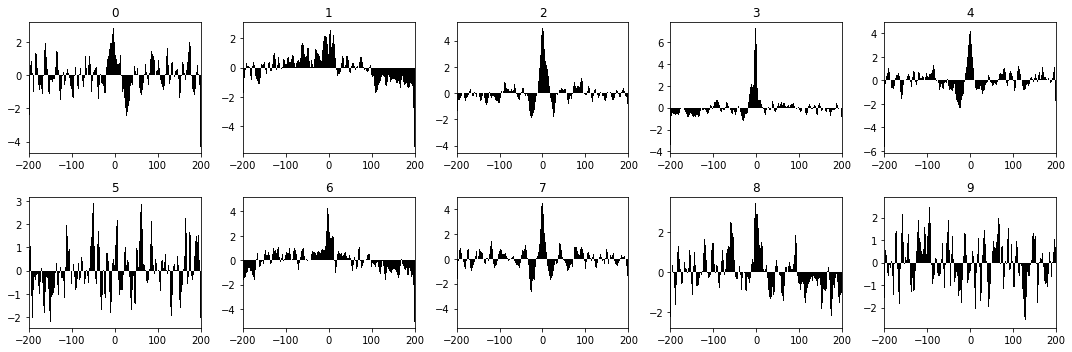

In [8]:
# get z-scored CCG
df['xcorr_z'] = df['xcorr_filtered'].apply(lambda x: zscore(x))
fig, axes = plt.subplots(2, 5, figsize=[15, 5]) 
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.bar(range(-200, 201), df['xcorr_z'][i], 1, color='k')
    ax.set_xlim([-200, 200])
    ax.set_title(i)
plt.tight_layout()

In [9]:
# get peak value of filtered CCG within 10ms around lag 0
df['peak'] = df['xcorr_z'].apply(lambda x: max(x[(201-10):(201+10)]))
# map feature member and stim
df['member'] = df['member'].apply(lambda x: '(w)' if x else '(o)')
# combine information of region, stim, membersip in a single column
df['region_stim_member'] = df[['region', 'stim', 'member']].apply(tuple, axis=1)
df['region_stim_member'] = df['region_stim_member'].apply(lambda x: '_'.join([str(y) for y in x]))
# only pairs with more than 100 spikes in their ccg are considered to remove noisy CCGs
df['xcorr_sig'] = df['xcorr'].apply(lambda x: sum(x[(201-10):(201+10)]) > 100 and min(x[(201-10):(201+10)]) > 0)

## Summary plots
#### average peak values of CCG in each recording vs membership, stim, region

In [10]:
# order for box plot
my_order = df.groupby(by=['region', 'stim', 'member'])['peak'].mean().iloc[::-1].index
my_order = ['_'.join([str(y) for y in x]) for x in my_order]
print(my_order)

['MGB_spon_(w)', 'MGB_spon_(o)', 'MGB_dmr_(w)', 'MGB_dmr_(o)', 'A1_spon_(w)', 'A1_spon_(o)', 'A1_dmr_(w)', 'A1_dmr_(o)']


In [11]:
def plot_significance_star(ax, p, x_bar, y_bar, y_star):
    if p < 0.05:
        ax.plot(x_bar, [y_bar, y_bar], 'k' )
        if p < 1e-3:
            ax.text((x_bar[0] + x_bar[1]) / 2, y_star, '***',
                     horizontalalignment='center', verticalalignment='center')
        elif p < 1e-2:
            ax.text((x_bar[0] + x_bar[1]) / 2, y_star, '**',
                     horizontalalignment='center', verticalalignment='center')
        else:
            ax.text((x_bar[0] + x_bar[1]) / 2, y_star, '*',
                     horizontalalignment='center', verticalalignment='center')

significance test: within vs outside cNE
MannwhitneyuResult(statistic=1231.0, pvalue=2.6852749088949397e-11)
MannwhitneyuResult(statistic=1420.0, pvalue=2.2646738526795173e-11)
MannwhitneyuResult(statistic=268.0, pvalue=1.1348795685400747e-05)
MannwhitneyuResult(statistic=280.0, pvalue=1.6606666950089026e-06)

significance test: spon vs dmr
MannwhitneyuResult(statistic=803.0, pvalue=0.28652447030049877)
MannwhitneyuResult(statistic=720.0, pvalue=0.8527717421866887)
MannwhitneyuResult(statistic=152.0, pvalue=0.8094739516199263)
MannwhitneyuResult(statistic=150.0, pvalue=0.8632664146869172)

significance test: A1 vs MGB
MannwhitneyuResult(statistic=403.0, pvalue=0.06593784892974239)
MannwhitneyuResult(statistic=274.0, pvalue=0.5483429354628135)
MannwhitneyuResult(statistic=402.0, pvalue=0.2122627285235471)
MannwhitneyuResult(statistic=306.0, pvalue=0.655966811514307)


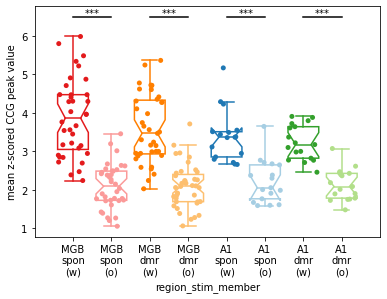

In [12]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

peak_mean = df.groupby(by=['exp','region', 'stim', 'member'], as_index = False)['peak'].mean()
peak_mean['region_stim_member'] = peak_mean[['region', 'stim', 'member']].apply(tuple, axis=1)
peak_mean['region_stim_member'] = peak_mean['region_stim_member'].apply(lambda x: '_'.join([str(y) for y in x]))
sns.stripplot(x='region_stim_member', y='peak', data=peak_mean, order=my_order, 
              hue='region_stim_member', palette=colors, hue_order=my_order, 
              jitter=0.4, legend=False)
bplot = sns.boxplot(x='region_stim_member', y='peak', data=peak_mean, order=my_order, notch=True, flierprops={'marker': ''})

for i,box_col in enumerate(colors):
    
    mybox = bplot.patches[i]
    
    mybox.set_edgecolor(box_col)
    mybox.set_facecolor('w')

    for j in range(i*6,i*6+6):
        line = bplot.lines[j]
        line.set_color(box_col)
        line.set_mfc(box_col)
        line.set_mec(box_col)

ax.set_xticklabels(['\n'.join(x.split('_')) for x in my_order])
ax.set_xlim([-1, 8])
ax.set_ylabel('mean z-scored CCG peak value');

# significance test for z-scored CCG peak value: within vs outside cNE
print('significance test: within vs outside cNE')
for i in range(4):
    res = stats.mannwhitneyu(x=peak_mean[peak_mean['region_stim_member'] == my_order[i*2]]['peak'], 
                       y=peak_mean[peak_mean['region_stim_member'] ==my_order[i*2+1]]['peak'], alternative = 'greater')
    print(res)
    p = res.pvalue
    plot_significance_star(ax, p, [i*2, i*2+1], 6.5, 6.6)

# significance test for z-scored CCG peak value: spon vs dmr
print('\nsignificance test: spon vs dmr')
for i in [0, 1, 4, 5]:
    res = stats.mannwhitneyu(x=peak_mean[peak_mean['region_stim_member'] == my_order[i]]['peak'], 
                       y=peak_mean[peak_mean['region_stim_member'] ==my_order[i + 2]]['peak'])
    print(res)
    
# significance test for z-scored CCG peak value: A1 vs MGB
print('\nsignificance test: A1 vs MGB')
for i in range(4):
    res = stats.mannwhitneyu(x=peak_mean[peak_mean['region_stim_member'] == my_order[i]]['peak'], 
                       y=peak_mean[peak_mean['region_stim_member'] ==my_order[i + 4]]['peak'])
    print(res)
    p = res.pvalue
    plot_significance_star(ax, p, [i, i+4], 7, 7.1)

#### correlation of spiketrains binned at 10ms  vs membership, stim, region

significance test: within vs outside cNE
MannwhitneyuResult(statistic=2636599.0, pvalue=3.434098762128102e-239) within = 0.0424 outside = 0.0109
MannwhitneyuResult(statistic=2624385.0, pvalue=5.588826195432694e-227) within = 0.0344 outside = 0.0078
MannwhitneyuResult(statistic=3066642.0, pvalue=2.0628825859286795e-238) within = 0.0400 outside = 0.0066
MannwhitneyuResult(statistic=2818830.0, pvalue=3.526240303765506e-203) within = 0.0355 outside = 0.0058

significance test: spon vs dmr
MannwhitneyuResult(statistic=507757.0, pvalue=4.9086747451746175e-11) spon median = 0.0424 dmr median = 0.0344
MannwhitneyuResult(statistic=6371361.0, pvalue=6.585216349687812e-25) spon median = 0.0109 dmr median = 0.0078
MannwhitneyuResult(statistic=517002.0, pvalue=0.00719778815244804) spon median = 0.0400 dmr median = 0.0355
MannwhitneyuResult(statistic=6714467.0, pvalue=0.02182471564613763) spon median = 0.0066 dmr median = 0.0058

significance test: A1 vs MGB
MannwhitneyuResult(statistic=503142.0, pv

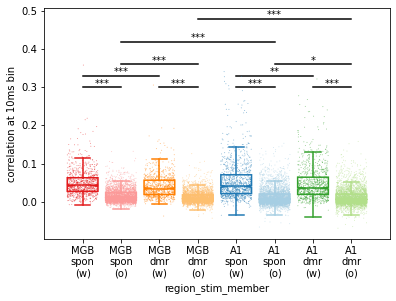

In [13]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) 

sns.stripplot(x='region_stim_member', y='corr', data=df, order=my_order, 
              hue='region_stim_member', palette=colors, hue_order=my_order, 
              size=1, alpha=0.5,
              jitter=0.4, legend=False)
bplot = sns.boxplot(x='region_stim_member', y='corr', data=df, order=my_order, notch=True, flierprops={'marker': ''})

for i,box_col in enumerate(colors):
    
    mybox = bplot.patches[i]
    
    mybox.set_edgecolor(box_col)
    mybox.set_facecolor('w')

    for j in range(i*6,i*6+6):
        line = bplot.lines[j]
        line.set_color(box_col)
        line.set_mfc(box_col)
        line.set_mec(box_col)

ax.set_xticklabels(['\n'.join(x.split('_')) for x in my_order])
ax.set_xlim([-1, 8])
ax.set_ylabel('correlation at 10ms bin');

# significance test for z-scored CCG peak value: within vs outside cNE
print('significance test: within vs outside cNE')
for i in range(4):
    res = stats.mannwhitneyu(x=df[df['region_stim_member'] == my_order[i*2]]['corr'], 
                       y=df[df['region_stim_member'] ==my_order[i*2+1]]['corr'], alternative = 'greater')
    print(res, 
          'within = {:.4f}'.format(df[df['region_stim_member'] == my_order[i*2]]['corr'].median()), 
          'outside = {:.4f}'.format(df[df['region_stim_member'] == my_order[i*2+1]]['corr'].median()))
    p = res.pvalue
    plot_significance_star(ax, p, [i*2, i*2+1], 0.3, 0.31)

# significance test for z-scored CCG peak value: spon vs dmr
print('\nsignificance test: spon vs dmr')
for i in [0, 1, 4, 5]:
    res = stats.mannwhitneyu(x=df[df['region_stim_member'] == my_order[i]]['corr'], 
                       y=df[df['region_stim_member'] ==my_order[i + 2]]['corr'])
    print(res, 
          'spon median = {:.4f}'.format(df[df['region_stim_member'] == my_order[i]]['corr'].median()), 
          'dmr median = {:.4f}'.format(df[df['region_stim_member'] == my_order[i + 2]]['corr'].median()))
    p = res.pvalue
    plot_significance_star(ax, p, [i, i + 2], 0.33+0.03*(i%4), 0.34+0.03*(i%4))
    
# significance test for z-scored CCG peak value: A1 vs MGB
print('\nsignificance test: A1 vs MGB')
for i in range(4):
    res = stats.mannwhitneyu(x=df[df['region_stim_member'] == my_order[i]]['corr'], 
                       y=df[df['region_stim_member'] ==my_order[i + 4]]['corr'])
    print(res, 
          'MGB median = {:.4f}'.format(df[df['region_stim_member'] == my_order[i]]['corr'].median()), 
          'A1 median = {:.4f}'.format(df[df['region_stim_member'] == my_order[i + 4]]['corr'].median()))
    p = res.pvalue
    plot_significance_star(ax, p, [i, i + 4], 0.39+0.03*i, 0.4+0.03*i)



**Observations:**

Neurons in the same cNE have more correlated firing compared to neurons not in the same cNE.   
Neurons have higher correlation in spontaneous activities compared to semsory-evoked activities.  
Neurons not in the same cNE have slightly higher correlation in MGB.

### Save DataFrame for Later Use

In [14]:
df.to_json(r'E:\Congcong\Documents\data\comparison\data-summary\member_nonmember_pair_xcorr_filtered.json')
df.head()

,xcorr,corr,member,stim,region,exp,xcorr_filtered,xcorr_z,peak,region_stim_member,xcorr_sig
0,"[18, 24, 19, 21, 21, 31, 17, 28, 18, 24, 17, 1...",0.014194,(w),dmr,MGB,191126211411,"[12.380059824183228, 16.275793655790316, 19.24...","[-4.340199149695802, -2.403608937782621, -0.92...",2.817812,MGB_dmr_(w),True
1,"[60, 58, 48, 54, 62, 58, 55, 55, 82, 60, 56, 6...",0.037981,(w),dmr,MGB,191126211411,"[33.84915519344174, 43.4137381009582, 50.04632...","[-4.435502325065141, -2.8584955551722953, -1.7...",2.682915,MGB_dmr_(w),True
2,"[119, 132, 117, 122, 122, 116, 132, 109, 120, ...",0.079390,(w),dmr,MGB,191126211411,"[73.74165885334075, 95.34321791979559, 109.837...","[-4.121411972525911, -2.465824315233235, -1.35...",4.930162,MGB_dmr_(w),True
3,"[100, 104, 104, 92, 97, 74, 96, 87, 98, 81, 10...",0.070183,(w),dmr,MGB,191126211411,"[60.39139928548959, 77.32884480254799, 87.7062...","[-3.4100111761630627, -1.7826574083157853, -0....",7.259384,MGB_dmr_(w),True
4,"[93, 86, 107, 106, 105, 104, 99, 99, 96, 128, ...",0.031959,(w),dmr,MGB,191126211411,"[57.55953047021093, 76.07541739609425, 89.8621...","[-5.695575764763863, -3.2189554185597853, -1.3...",4.420475,MGB_dmr_(w),True
